# Gas Discharge & Stellar Feedback-driven Outflows (Part 3 /3):
## Ram Pressure, Reaccretion Times, Distributions
`-- Leo Lonzarich, 17 November 2021 // [Updated 11-12-21] --`


### Table of Contents
- [Ram Pressure Calculations for Discharged Gas](#ram)
    - [Identifying Ram Pressures](#ramdis)
    
- [Reaccretion Times](#acctime)
    - [General Reaccretion Times](#gen)
    - [Supernova Heating](#sne)
    - [Distance Distributions](#dis)
    - [Velocity Distributions](#vel)


### General Comments on Data/Contents of this Noteboook
- Repeat occurance of particle ids (`pids`) in data sets below typically a result of particle being discharged/accreted more than once. (Checking timesteps of repeated pid should verify this.)


- The datasets: (each logs the properties (stored in `keys`) for their respective particles for the specified point relative to their differentiating event.)

    1. **Ejected/Expelled Data (from H. Akins):**
        - *Ejected*: Gas particles that have been removed from their respective satellite galaxy's disk to the halo. (Properties for **timestep after ejection**.)
        - *Expelled*: Gas particles (within the disk or halo of their respective satellite galaxy) that have been removed beyond the virial radius of their satellite; that is, all gas particles removed to the field. (Again, properties given for **timestep after expullsion**.)
        <br><br>
    2. **Discharge Data (From L. Lonzarich):**
        - *Discharged*: Gas particles that have been removed from the disk of their respective satellite galaxy. This includes both gas moved to halo, and that moved beyond the virial radius. (Properties given for **timestep after discharge event**.)
        - *Predischarged*: A collection of the same particles in *Discharged*, but instead giving the properties of each particle prior to their discharge event (thereby allowing pre- and post-discharge comparisons).
        - *Heated*: Gas particles in *Discharged* that experienced supernova(e) heating (functionally, their 'cooling' was turned off) in the timestep prior to being discharged. (Note: this dataset can be also be obtained by selecting particles from *Discharged* with `sneHeated==True`.)
        - *Preheated*: Similar to *Predischarged*; Consists of the same particles in *Heated*, but with properties of each particle for the timestep prior to discharge.
        <br><br>
        - *Accreted*: Gas particles in the halo or beyond the virial radius of a satellite that are accreted onto the satellite's disk. (Properties given for **timestep following accretion event**.) Note that this includes particles that were previously discharged from the satellite's disk, and those that were not. 
        - *Reaccreted*: A subset of *Accreted*; Gas particles in the halo or beyond the virial radius of a satellite as a result of a prior discharge event that are reaccreted onto the satellite's disk. (Properties given for **timestep following reaccretion event**.)


    
    
- Noteworthy measures and their units (unless where otherwise noted):
    - *Time* is in Gigayears $(Gyrs)$.
    - *Distances* in kiloparsecs $(kpc)$.
    - *Velocities* in kilometers per second $(km \ s^{-1})$.
    - *Masses* in solar masses $(M_{sol})$.
    - *Gravitational Constant* G in ($kpc\ km^2\ M_{sol}^{-1}\ s^{-2})$

In [2]:
import numpy as np
import pylab
import pynbody
import pynbody.plot.sph as sph
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

from astropy import units
from astropy import constants as c

import warnings
warnings.filterwarnings("ignore")

from compiler import *
from analysis import * 
from ramdischarge import *

In [3]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [5]:
path = f'{rootPath}Stellar_Feedback_Code/SNeData/discharged_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

# listing dwarf galaxies of simulations that are viable for study (gaseous, satellite, etc).
print(len(keys), 'Available Keys:\n', *keys)

19 Available Keys:
 h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33


## Ram Pressure Stripping  <a class="anchor" id="ram"></a>

For this part, we use ram stripping data collected for each discharged gas particle to see if we can flesh out any differences in the exit angles between discharged and heated gas not visible in initial exit angle plots (see Part 1 of this notebook for reference).
____
____



### Picking out Ram Pressures for Discharged Particles <a class="anchor" id="ramdis"></a>

In [4]:
pram = read_all_ram_pressure()

1 > Returning (predischarged, discharged, adv. accreted, preheated, heated) for all available satellites <
2 > Returning (predischarged, discharged, adv. accreted, preheated, heated) for all available satellites <
3 > Returning (predischarged, discharged, adv. accreted, preheated, heated) for all available satellites <
4 > Returning (predischarged, discharged, adv. accreted, preheated, heated) for all available satellites <
5 > Returning (predischarged, discharged, adv. accreted, preheated, heated) for all available satellites <
6 > Returning (predischarged, discharged, adv. accreted, preheated, heated) for all available satellites <
7 > Returning (predischarged, discharged, adv. accreted, preheated, heated) for all available satellites <
8 > Returning (predischarged, discharged, adv. accreted, preheated, heated) for all available satellites <
9 > Returning (predischarged, discharged, adv. accreted, preheated, heated) for all available satellites <
10 > Returning (predischarged, discha

## Reaccretion Times  <a class="anchor" id="acctime"></a>

For this treatment, we define the new parameter

$$
    reaccretion\ time = time\ at\ reaccretion - time\ at\ discharge
$$

(in practice, 'time at reaccretion' is the timestep just following a reaccretion event for a gas particle, and 'time at discharged' is the timestep just following a corresponding discharge event for said particle). These reaccretion times can be called via the `.recycleTime` key of the *reaccreted* dataset.


Finally, define 

$$
M_{reac}
$$

to be the collective mass of all reaccreted particles --- functionally, the sum of the masses of every gas particle in the *reaccreted* dataset. We will use this to both normalize our data, and determine what fractions of reaccreted particles (in terms of mass) adhere to particular critera.
____
____



### General Distribution of Reaccretion Times <a class="anchor" id="gen"></a>

In [6]:
predischarged, discharged, preheated, heated = read_all_discharged()
all_accreted, reaccreted = read_accreted()

> Returning (predischarged, discharged, adv. accreted, preheated, heated) for all satellites <
> Returning (all_accreted, reaccreted) for all satellites <


In [8]:
# pulling subset of discharged gas that did not experience SNe heating prior to discharge.
cooled = discharged[discharged.sneHeated==False]

In [9]:
# creating weight attributes for plotting.
predischarged['weight'] = predischarged['mass'] / predischarged['mass'].sum()
discharged['weight'] = discharged['mass'] / discharged['mass'].sum()
cooled['weight'] = cooled['mass']/cooled['mass'].sum() #discharged['mass'].sum() #cooled['mass'].sum()
reaccreted['weight'] = reaccreted['mass'] / reaccreted['mass'].sum()

preheated['weight'] = preheated['mass'] / preheated['mass'].sum()
heated['weight'] = heated['mass'] / heated['mass'].sum() #discharged['mass'].sum() #heated['mass'].sum()

In [10]:
# Comparing all accreted and reaccreted:
display(all_accreted, reaccreted)

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,key
176387,10.783935,2202002,0.142927,8746.030273,28038.187315,1.502397,0.601453,0.011168,-0.119313,-0.324524,...,18.586025,True,False,False,False,False,False,1.001308e+10,45.412102,h148_13
219395,12.076876,2202002,0.131769,7552.754883,28840.956689,10.908183,0.329223,0.005613,0.111963,-0.214933,...,18.811293,True,False,False,False,False,False,9.621392e+09,99.905440,h148_13
103082,9.060013,2857672,2.172691,2506.807373,26593.440078,0.000000,0.369888,0.007470,0.273438,-0.185580,...,17.831585,True,False,False,False,False,False,1.195771e+10,130.124554,h148_13
147207,10.352954,4073949,0.525808,4238.500000,26658.696866,0.000000,0.514738,0.009778,-0.412274,0.303749,...,19.590469,True,False,False,False,False,False,1.036817e+10,53.446752,h148_13
176391,10.783935,4073949,0.332782,2948.533447,26839.452610,0.000000,0.687113,0.012759,-0.619439,-0.231153,...,18.586025,True,False,False,False,False,False,1.001308e+10,59.700159,h148_13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13095,7.767072,6628859,2.757110,8886.482422,26513.626324,0.000000,0.291548,0.010300,0.031189,0.212495,...,12.023541,True,False,False,False,False,False,3.202585e+09,50.999123,h329_33
26213,8.608831,6628979,0.123141,10599.953125,26589.511131,0.000000,0.424728,0.036870,0.224581,0.310447,...,9.596679,True,False,False,False,False,False,1.604989e+09,124.137821,h329_33
17474,8.090307,6630126,0.315700,10079.164062,26695.281840,0.000000,0.406475,0.013873,-0.381672,0.139252,...,11.540393,True,False,False,False,False,False,3.232682e+09,83.842541,h329_33
30593,8.736778,6630131,0.115406,10597.738281,26557.970752,0.000000,3.622564,0.246604,-0.620991,-0.292862,...,11.289288,True,False,False,False,False,False,1.858121e+09,51.927387,h329_33


,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,recycleTime,sneHeated,key,weight
219395,12.076876,2202002,0.131769,7552.754883,28840.956689,10.908183,0.329223,0.005613,0.111963,-0.214933,...,False,False,False,False,9.621392e+09,99.905440,0.861961,True,h148_13,0.000009
176391,10.783935,4073949,0.332782,2948.533447,26839.452610,0.000000,0.687113,0.012759,-0.619439,-0.231153,...,False,False,False,False,1.001308e+10,59.700159,0.016835,False,h148_13,0.000009
176395,10.783935,4340176,0.401898,2652.002686,27086.295834,10.685118,0.428320,0.007953,-0.178513,-0.216064,...,False,False,False,False,1.001308e+10,26.191299,0.016835,True,h148_13,0.000009
233228,12.150951,6936050,0.560197,1397.095459,27697.543286,11.744889,0.390005,0.006615,-0.208407,-0.174504,...,False,False,False,False,9.613553e+09,118.209595,1.797996,False,h148_13,0.000009
246998,12.507856,6988228,0.265469,2674.128662,26987.662856,11.038656,0.556688,0.009209,-0.346464,-0.008945,...,False,False,False,False,9.585598e+09,61.624421,1.292941,True,h148_13,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30570,8.736778,6627712,0.526319,9594.726562,26645.238280,4.748210,0.342840,0.023339,0.061558,-0.196127,...,False,False,False,False,1.858121e+09,138.353519,0.127947,False,h329_33,0.000009
26201,8.608831,6627722,0.138480,10518.361328,26602.553508,0.000000,0.303652,0.026359,-0.213029,0.208620,...,False,False,False,False,1.604989e+09,145.056225,0.518523,False,h329_33,0.000009
13091,7.767072,6627756,0.115487,11003.851562,26526.509817,0.000000,0.576517,0.020367,0.452256,0.322808,...,False,False,False,False,3.202585e+09,94.449576,0.323235,False,h329_33,0.000009
30580,8.736778,6627757,0.106789,10646.407227,26584.817118,0.000000,3.666577,0.249600,-0.559055,-0.269244,...,False,False,False,False,1.858121e+09,48.938695,0.323235,False,h329_33,0.000009


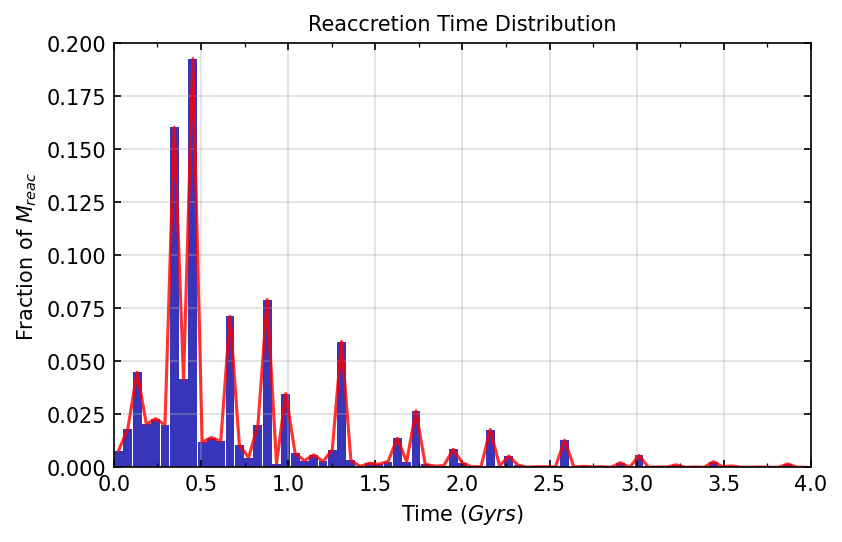

In [96]:
## basic histogram of accretion times to get a general sense of what the distribution looks like ##

bins = 75
fig, ax = plt.subplots(1,1,dpi=150, figsize=(5.5,3.5), constrained_layout=True) # change to dpi=300 for printout.


# sne-heated pre-discharge.
y1, x = np.histogram(reaccreted.recycleTime, bins=bins, weights=reaccreted.weight, range=(0, 4))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, alpha=0.8, c='red')

# sne-heated discharge.
ax.hist(reaccreted.recycleTime, bins=bins, weights=reaccreted.weight, color='#0504aa', alpha=0.8, rwidth=0.95,\
        range=(0, 4))

ax.set_title('Reaccretion Time Distribution', fontsize='medium')
ax.set_xlabel(r'Time ($Gyrs$)')
ax.set_ylabel('Fraction of $M_{reac}$')
ax.set_xlim(0,4)
ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')

plt.show()

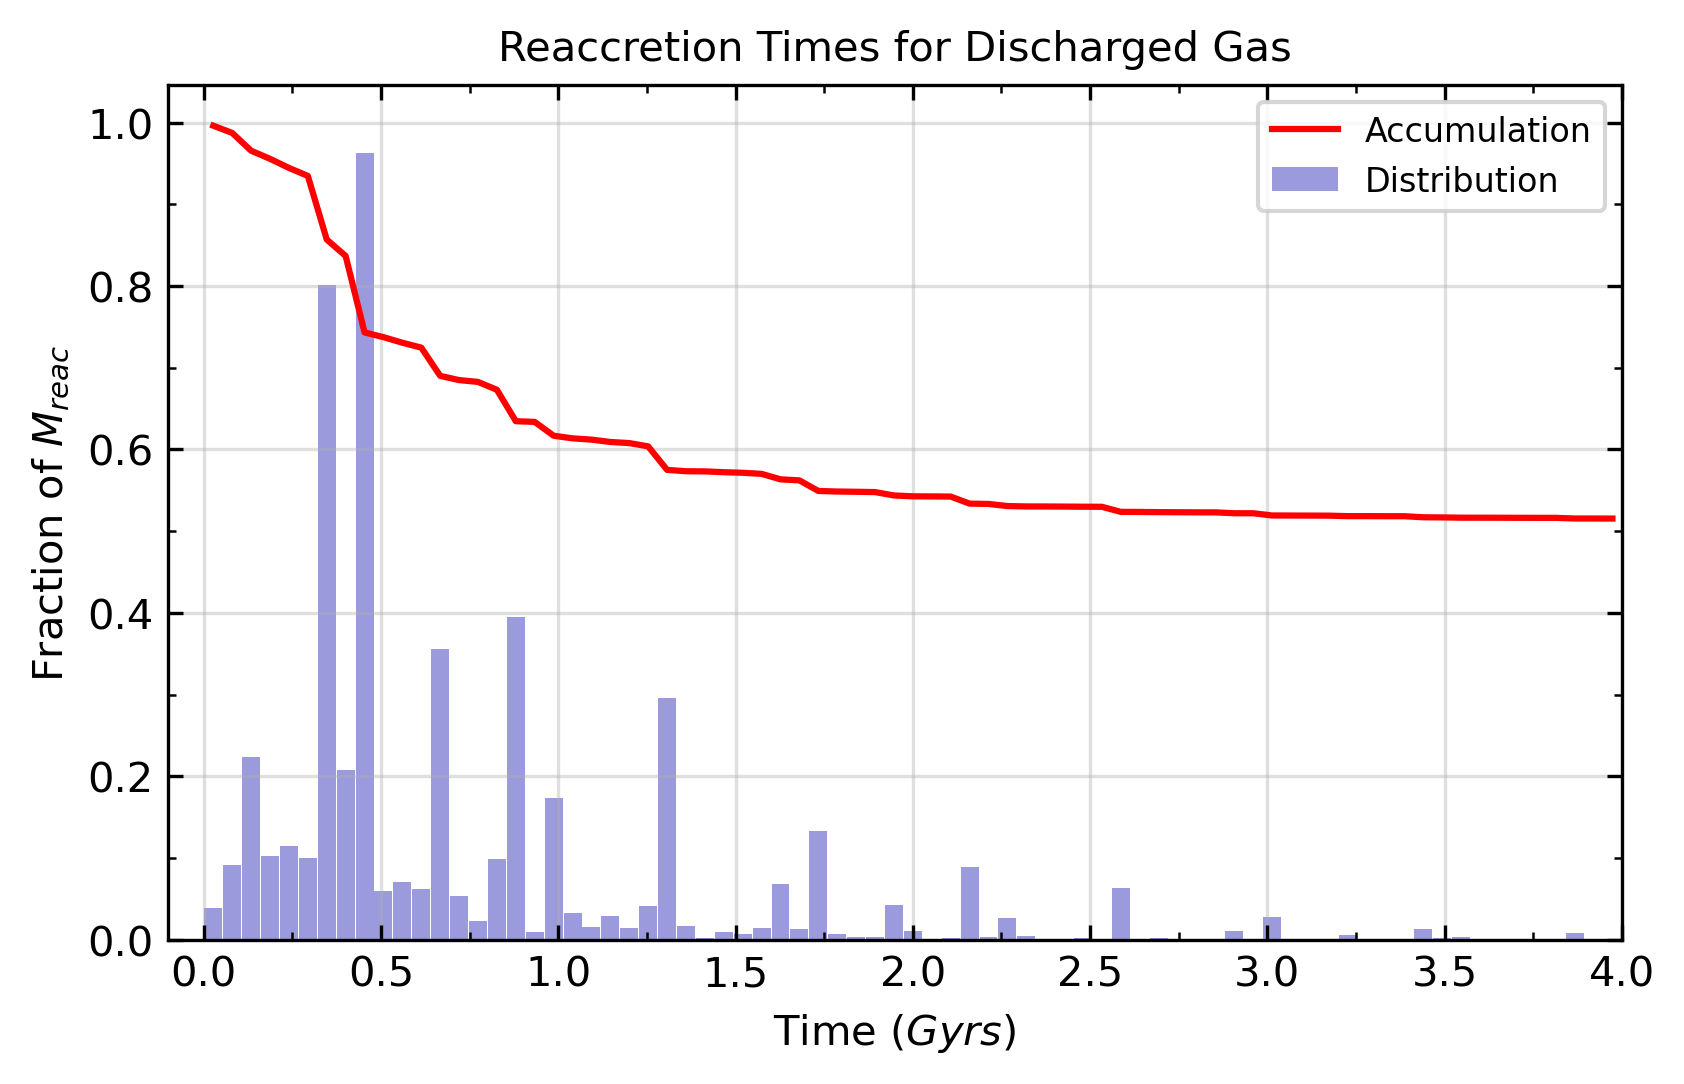

In [73]:
## basic histogram of reaccretion times w/ accumulation plot to get a general sense of the distribution ##

bins = 75
fig, ax = plt.subplots(1,1,dpi=300, figsize=(5.5,3.5), constrained_layout=True) # change to dpi=300 for printout.


# accumulation plot.
y1, x = np.histogram(reaccreted.recycleTime, bins=bins, weights=reaccreted['mass']/np.sum(discharged['mass']), range=(0, 4))
bincenters = 0.5*(x[1:] + x[:-1])

sum = np.cumsum(y1) #-(np.sum(reaccreted['mass'])/np.sum(discharged['mass']))
ax.plot(bincenters, 1-sum, alpha=1.0, c='red', label='Accumulation')

# general distribution histogram; scaling weights by 5 to make histogram visible against accum. plot.
ax.hist(reaccreted.recycleTime, bins=bins, weights=5*reaccreted.weight, color='#0504aa', alpha=0.4, rwidth=0.95,\
        range=(0, 4), label='Distribution')

ax.set_title('Reaccretion Times for Discharged Gas', fontsize='medium')
ax.set_xlabel(r'Time ($Gyrs$)')
ax.set_ylabel('Fraction of $M_{reac}$')
ax.set_xlim(-0.1,4)
# ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

ax.legend(frameon=True, fontsize='8')

# plt.savefig('plots/reaccretion_dist.pdf')

plt.show()

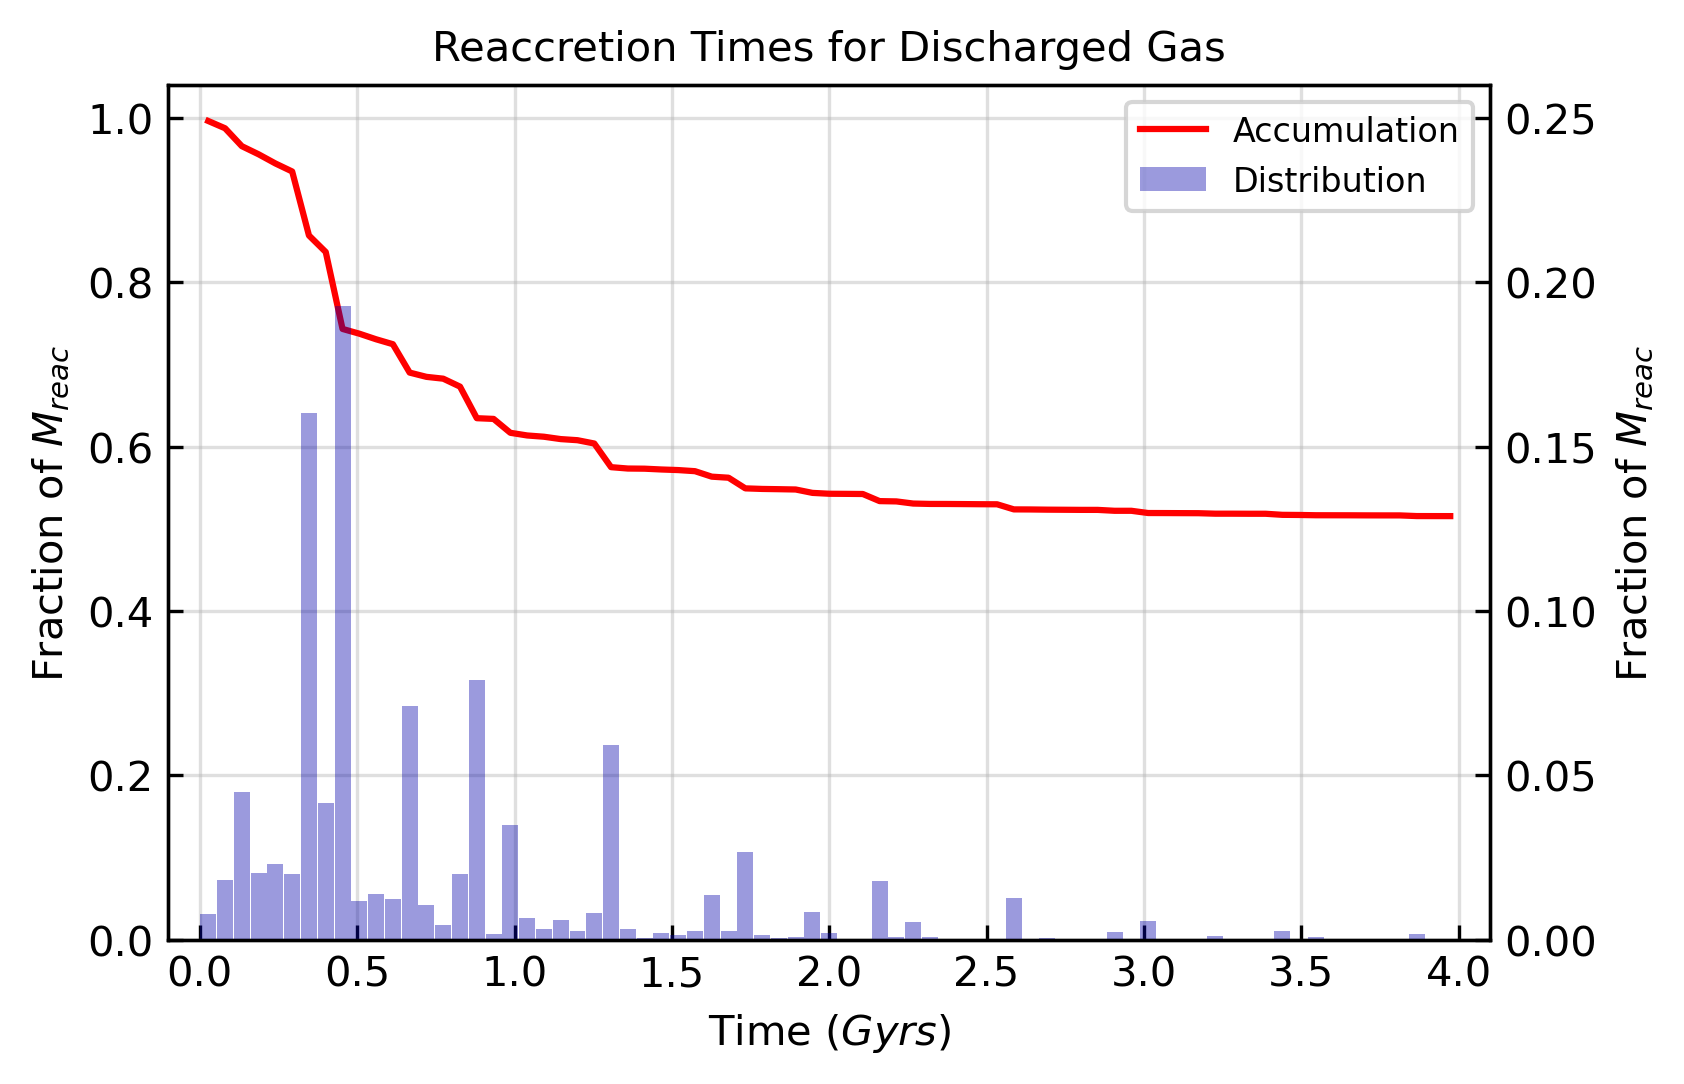

In [98]:
### basic histogram of reaccretion times w/ accumulation plot ###
# ax1 = accumulation plot;
# ax2 = histogram marking the percentage of reaccreted particles falling within specified reaccretion time bins.

bins = 75
rangemax = 4.0
fig, ax1 = plt.subplots(1,1,dpi=300, figsize=(5.5,3.5), constrained_layout=True) # change to dpi=300 for printout.
ax2 = ax1.twinx()

# accumulation plot:
y1, x = np.histogram(reaccreted.recycleTime, bins=bins, weights=reaccreted['mass']/np.sum(discharged['mass']),\
        range=(0, rangemax))
bincenters = 0.5*(x[1:] + x[:-1])
sum = np.cumsum(y1) #-(np.sum(reaccreted['mass'])/np.sum(discharged['mass']))
ax1.plot(bincenters, 1-sum, alpha=1.0, c='red', label='Accumulation')

# histogram:
ax2.hist(reaccreted.recycleTime, bins=bins, weights=reaccreted.weight,  color='#0504aa', alpha=0.4,\
        rwidth=0.95, range=(0,rangemax), label='Distribution')


ax1.set_title('Reaccretion Times for Discharged Gas', fontsize='medium')
ax1.set_xlabel(r'Time ($Gyrs$)')
ax1.set_ylabel('Fraction of $M_{reac}$')
ax2.set_ylabel('Fraction of $M_{reac}$')


# # ask matplotlib for the plotted objects and their labels to make joined legend.
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc=0, fontsize='8')

ax1.set_xlim(-0.1,4.1)
ax1.set_ylim(0,1.04)
ax2.set_ylim(0,0.26)

ax1.tick_params(direction='in',which='both')
ax2.tick_params(direction='in',which='both')
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
 
ax1.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax1.grid(alpha=0.4, zorder=-1000)

plt.savefig('plots/reaccretion_dist.pdf')

plt.show()

Alright, so this distribution suggests a significant portion of gas reaccreted is accreted rather quickly. Now, it would be nice if we could pick out some correlations. Let us start by looking at the relationships (or lack thereof) between accretion times and 

1) Supernova heating;

2) Distance discharged from satellite disk;

3) Degree of Ram Pressure Stripping; 

5) Exit/Entrance velocities at discharge; 

4) Temperatures.

<!-- filter for parameters (compare between discharged and accreted -- what discharged are not reaccreted) -->

### SNe Heating vs. Reaccretion Times <a class="anchor" id="sne"></a>

We start off looking at the dynamic between reaccretion time and a gas particle's state of SNe heating (heated or not).

In [29]:
predischarged, discharged, preheated, heated = read_all_discharged()
all_accreted, reaccreted = read_accreted()

> Returning (predischarged, discharged, adv. accreted, preheated, heated) for all satellites <
> Returning (all_accreted, reaccreted) for all satellites <


In [63]:
# splitting reaccreted set into subsets based on whether reaccreted gas particles experienced SNe-heating prior to 
# discharge or not. 
cold_acc = reaccreted[reaccreted.sneHeated==False]
hot_acc = reaccreted[reaccreted.sneHeated==True]

# creating weight attributes for plotting.
cold_acc['weight'] = cold_acc['mass'] / discharged[discharged.sneHeated==False]['mass'].sum()
hot_acc['weight'] = hot_acc['mass'] / discharged[discharged.sneHeated==True]['mass'].sum()

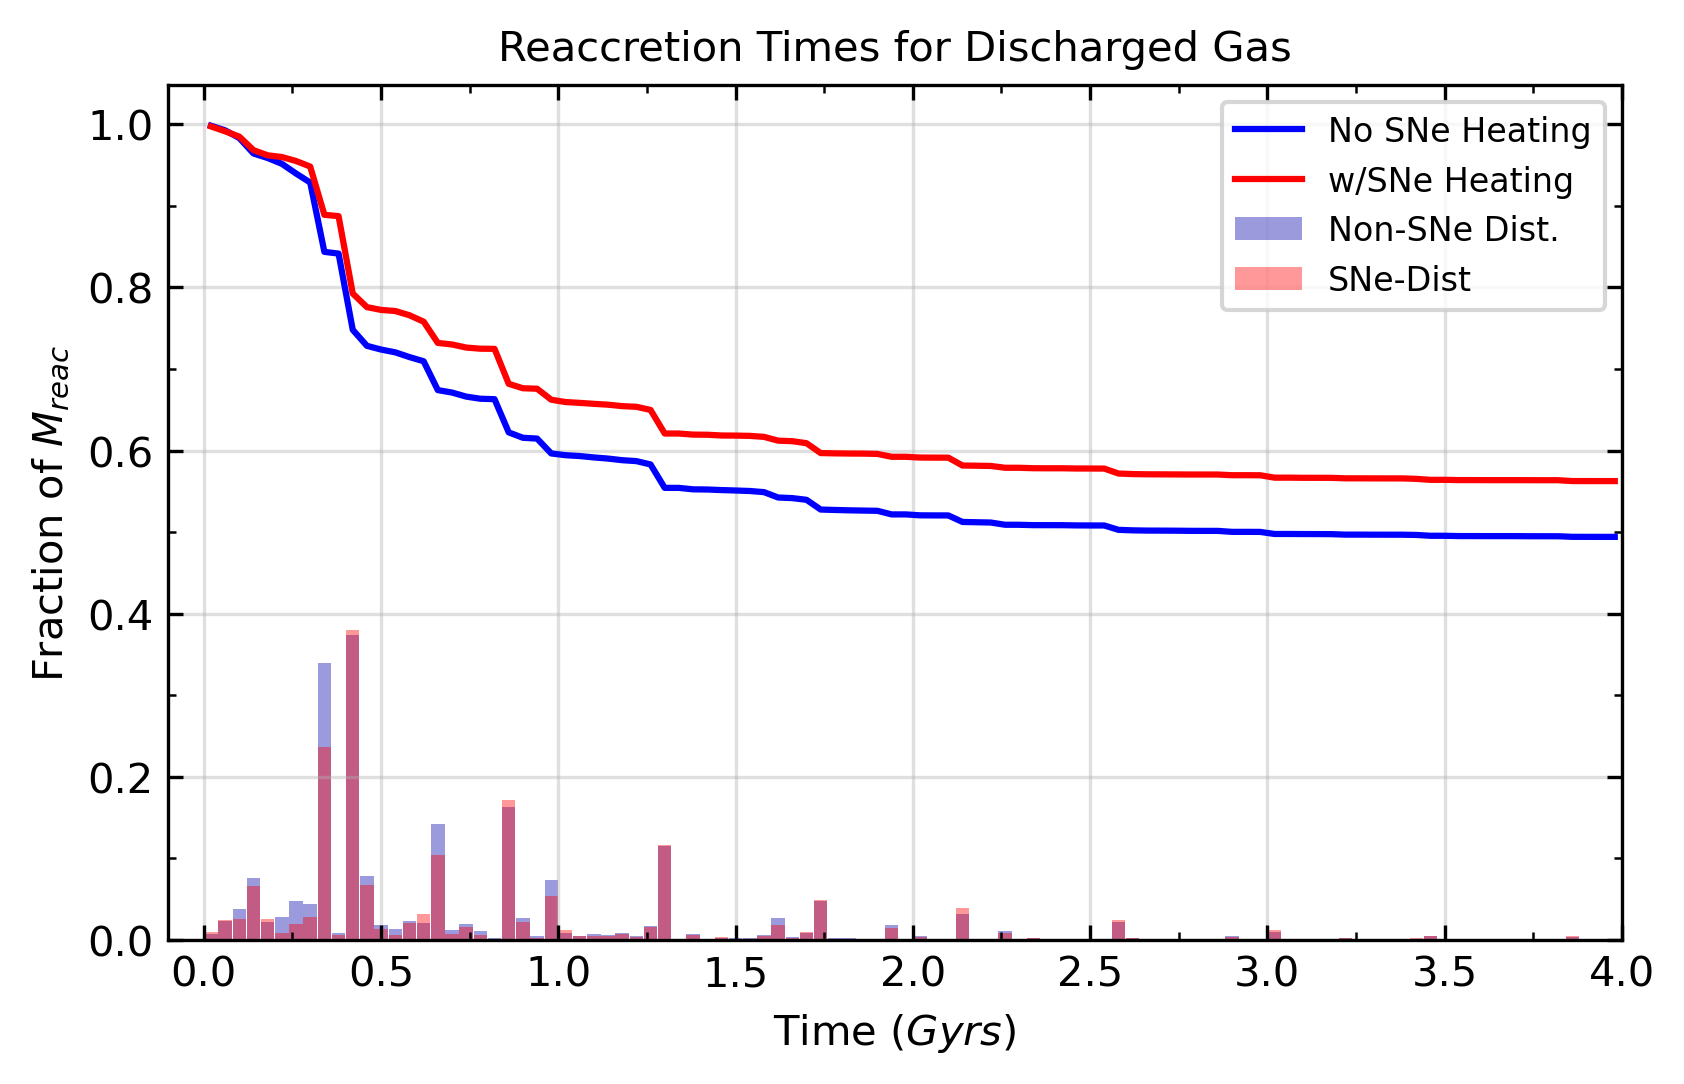

In [85]:
## histogram of reaccretion times comparing heated vs unheated gas ##
bins = 100
fig, ax = plt.subplots(1,1,dpi=300, figsize=(5.5,3.5), constrained_layout=True) # change to dpi=300 for printout.


# accumulation plot for non-SNe-heated.
y1, x = np.histogram(cold_acc.recycleTime, bins=bins, weights=cold_acc.weight, range=(0, 4))
bincenters = 0.5*(x[1:] + x[:-1])
sum = 1 - np.cumsum(y1)
ax.plot(bincenters, sum, alpha=1.0, c='blue', label='No SNe Heating')

# accumulation plot for SNe-heated.
y1, x = np.histogram(hot_acc.recycleTime, bins=bins, weights=hot_acc.weight, range=(0, 4))
bincenters = 0.5*(x[1:] + x[:-1])
sum = 1 - np.cumsum(y1)
ax.plot(bincenters, sum, alpha=1.0, c='red', label='w/SNe Heating')


# general distribution histogram; scaling weights by 5 to make histogram visible against accum. plot.
ax.hist(cold_acc.recycleTime, bins=bins, weights=4*cold_acc.weight, color='#0504aa', alpha=0.4, rwidth=0.95,\
        range=(0, 4), label='Non-SNe Dist.')
ax.hist(hot_acc.recycleTime, bins=bins, weights=4*hot_acc.weight, color='red', alpha=0.4, rwidth=0.95,\
        range=(0, 4), label='SNe-Dist')

ax.set_title('Reaccretion Times for Discharged Gas', fontsize='medium')
ax.set_xlabel(r'Time ($Gyrs$)')
ax.set_ylabel('Fraction of $M_{reac}$')
ax.set_xlim(-0.1,4)
# ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

ax.legend(frameon=True, fontsize='8')

# plt.savefig('plots/reacc_sne.pdf')

plt.show()

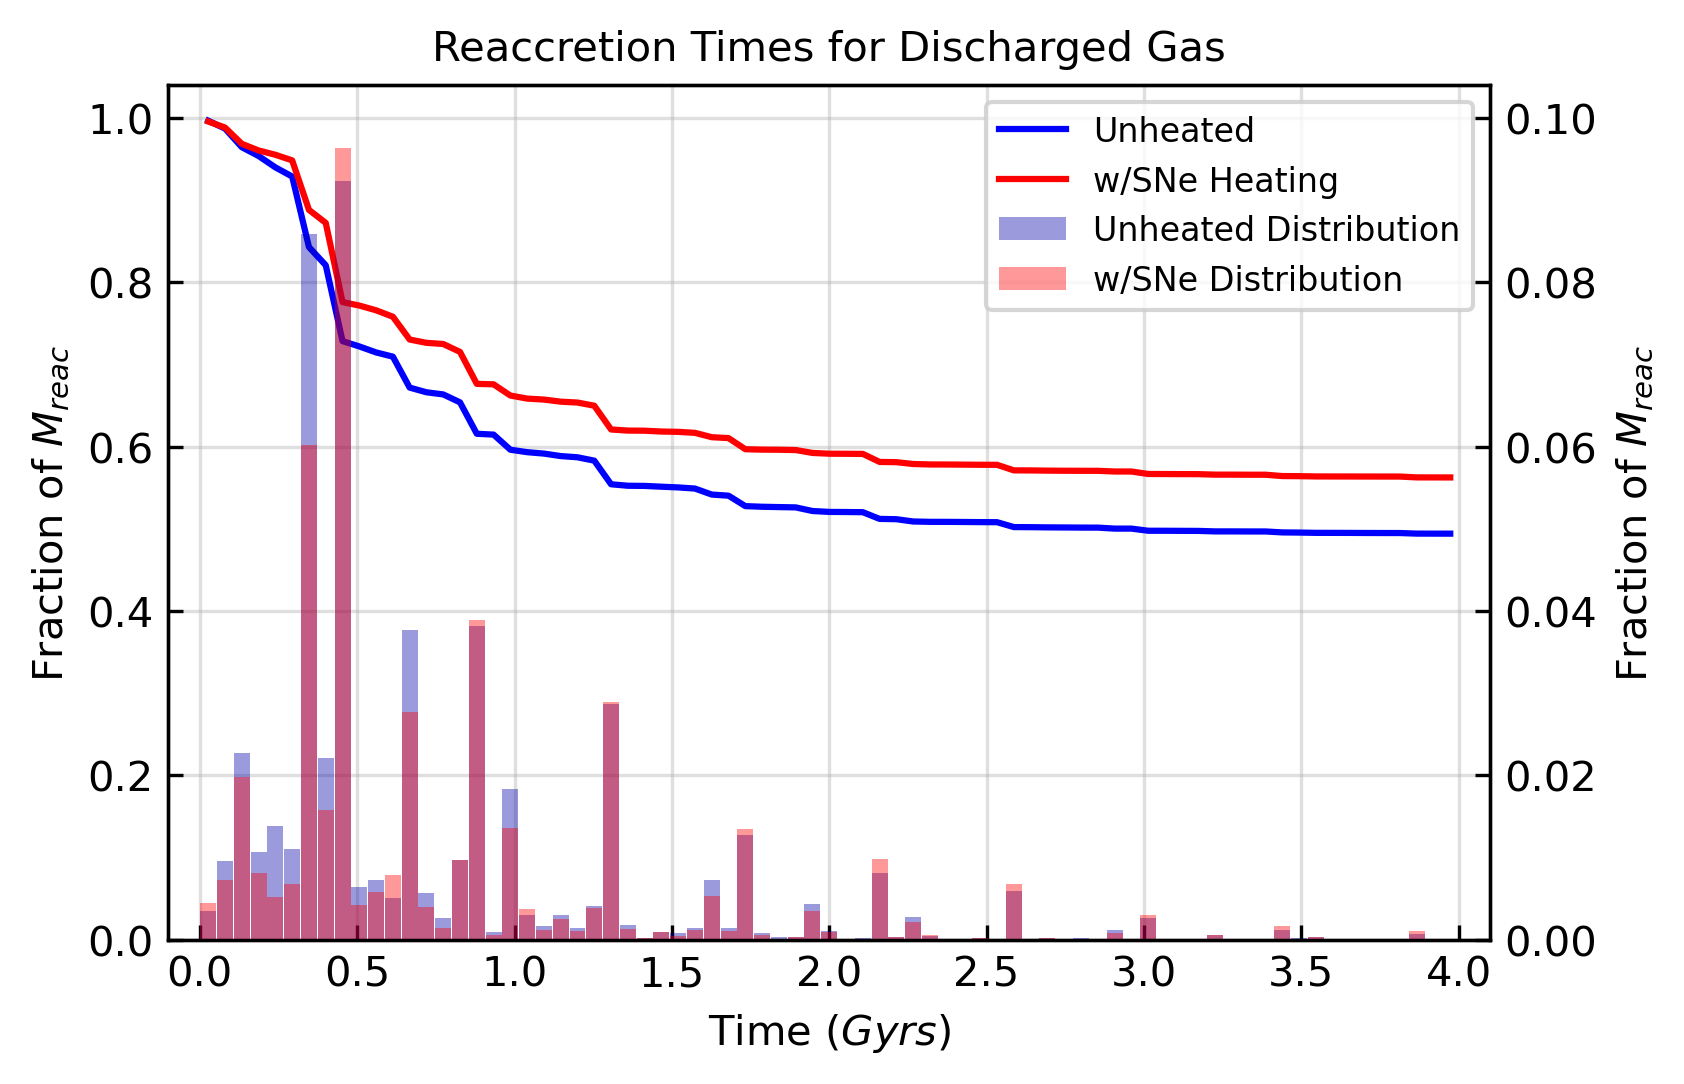

In [99]:
### basic histogram of reaccretion times w/ accumulation plot ###
# ax1 = accumulation plots;
# ax2 = histograms marking the percentage of reaccreted particles falling within specified reaccretion time bins.

bins = 75
rangemax = 4.0
fig, ax1 = plt.subplots(1,1,dpi=300, figsize=(5.5,3.5), constrained_layout=True) # change to dpi=300 for printout.
ax2 = ax1.twinx()

# accumulation plot:
# accumulation plot for non-SNe-heated.
y1, x = np.histogram(cold_acc.recycleTime, bins=bins, weights=cold_acc.weight, range=(0, 4))
bincenters = 0.5*(x[1:] + x[:-1])
sum = 1 - np.cumsum(y1)
ax1.plot(bincenters, sum, alpha=1.0, c='blue', label='Unheated')

# accumulation plot for SNe-heated.
y1, x = np.histogram(hot_acc.recycleTime, bins=bins, weights=hot_acc.weight, range=(0, 4))
bincenters = 0.5*(x[1:] + x[:-1])
sum = 1 - np.cumsum(y1)
ax1.plot(bincenters, sum, alpha=1.0, c='red', label='w/SNe Heating')

# histograms:
ax2.hist(cold_acc.recycleTime, bins=bins, weights=cold_acc.weight, color='#0504aa', alpha=0.4, rwidth=0.95,\
        range=(0, 4), label='Unheated Distribution')
ax2.hist(hot_acc.recycleTime, bins=bins, weights=hot_acc.weight, color='red', alpha=0.4, rwidth=0.95,\
        range=(0, 4), label='w/SNe Distribution')


ax1.set_title('Reaccretion Times for Discharged Gas', fontsize='medium')
ax1.set_xlabel(r'Time ($Gyrs$)')
ax1.set_ylabel('Fraction of $M_{reac}$')
ax2.set_ylabel('Fraction of $M_{reac}$')


# # ask matplotlib for the plotted objects and their labels to make joined legend.
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc=0, fontsize='8')

ax1.set_xlim(-0.1,4.1)
ax1.set_ylim(0,1.04)
ax2.set_ylim(0,0.104)

ax1.tick_params(direction='in',which='both')
ax2.tick_params(direction='in',which='both')
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
 
ax1.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax1.grid(alpha=0.4, zorder=-1000)

plt.savefig('plots/reacc_sne.pdf')

plt.show()

### Distance Relations <a class="anchor" id="dis"></a>

Looking at relationships between distance discharged from satellite disk and time taken for reaccretion.

### Velocity Relations <a class="anchor" id="vel"></a>

Looking at relationships between exit velocities of particles from their satellite's disks and the time taken for accretion.

In [18]:
predischarged, discharged, reaccreted, preheated, heated = read_all_discharged()

> Returning (predischarged, discharged, adv. accreted, preheated, heated) <


### Code Testing <a class="anchor" id="proving"></a>

Testing out different data types and computations.